## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [162]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [163]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [164]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [165]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [166]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [167]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [168]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [169]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [170]:
target = 'survived'

In [171]:
#vars_num = data.select_dtypes('number').columns.tolist() # fill your code here
vars_num = [var for var in data.columns if data[var].dtype != "O" and var != target]

#vars_cat = data.select_dtypes('object').columns.tolist() # fill your code here
vars_cat = [var for var in data.columns if data[var].dtype == "O"]

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

In [172]:
vars_cat

['sex', 'cabin', 'embarked', 'title']

In [173]:
data[vars_num].isnull().sum() > 0

pclass    False
age        True
sibsp     False
parch     False
fare       True
dtype: bool

In [174]:
# first numerical variables 
vars_num_with_na = [
    var for var in vars_num
    if data[var].isnull().sum() > 0
]

# print percentage of missing variables

data[vars_num_with_na].isnull().mean()

age     0.200917
fare    0.000764
dtype: float64

In [175]:
# now in categorical variables
vars_cat_with_na = [
    var for var in vars_cat
    if data[var].isnull().sum() > 0
]

data[vars_cat_with_na].isnull().sum()

cabin       1014
embarked       2
dtype: int64

### Determine cardinality of categorical variables

In [176]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

### Determine the distribution of numerical variables

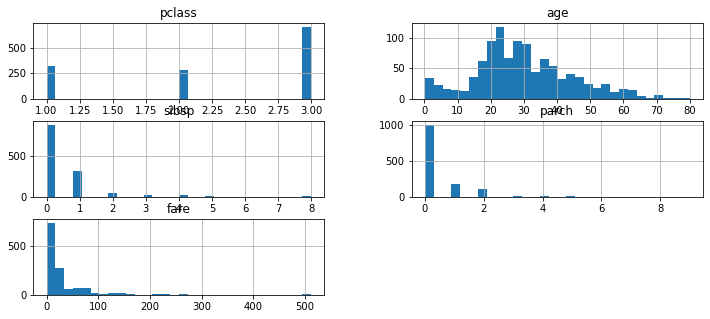

In [177]:
data[vars_num].hist(bins=30,figsize=(12,5))
plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [178]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [179]:
X_train['cabin'] = X_train["cabin"].str[0]
X_test['cabin'] = X_test['cabin'].str[0]

X_train['cabin'].unique()

array([nan, 'E', 'F', 'A', 'C', 'D', 'B', 'T', 'G'], dtype=object)

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [180]:
for var in vars_num_with_na:
    median_val = X_train[var].median()

    # add binary missing indicator
    X_train[var + '_na'] = np.where(X_train[var].isnull(),1,0)
    X_test[var + '_na'] = np.where(X_test[var].isnull(), 1, 0)
    
    # replace missing values by median
    X_train[var].fillna(median_val, inplace=True)
    X_test[var].fillna(median_val, inplace = True)
    
X_train[vars_num_with_na].isnull().sum()

age     0
fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [181]:
X_train[vars_cat] = X_train[vars_cat].fillna('Missing')
X_test[vars_cat] = X_test[vars_cat].fillna('Missing')

In [182]:
### Remove rare labels in categorical variables
##- remove labels present in less than 5 % of the passengers
def frequent_labels(df, var, rare_pc):
    df = df.copy()
    tmp = df.groupby(var)[var].count()/len(df)
    return tmp [tmp > rare_pc].index

In [183]:
for var in vars_cat:
    frequent_cat = frequent_labels(X_train,var,0.05)
    
    print(var,frequent_cat)
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_cat), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_cat), X_test[var], 'Rare')

sex Index(['female', 'male'], dtype='object', name='sex')
cabin Index(['C', 'Missing'], dtype='object', name='cabin')
embarked Index(['C', 'Q', 'S'], dtype='object', name='embarked')
title Index(['Miss', 'Mr', 'Mrs'], dtype='object', name='title')


In [184]:
X_train[vars_cat].nunique()

sex         2
cabin       3
embarked    4
title       4
dtype: int64

In [185]:
X_test[vars_cat].nunique()

sex         2
cabin       3
embarked    3
title       4
dtype: int64

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [157]:
pd.concat([X_train, 
                         pd.get_dummies(X_train[var], prefix = var, drop_first = True)],axis=1)

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na,title_Mr,title_Mrs,title_Rare
1118,3,male,25.0000,0,0,7.9250,Missing,S,Mr,0,0,1,0,0
44,1,female,41.0000,0,0,134.5000,Rare,C,Miss,0,0,0,0,0
1072,3,male,28.0000,0,0,7.7333,Missing,Q,Mr,1,0,1,0,0
1130,3,female,18.0000,0,0,7.7750,Missing,S,Miss,0,0,0,0,0
574,2,male,29.0000,1,0,21.0000,Missing,S,Mr,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,3,female,0.1667,1,2,20.5750,Missing,S,Miss,0,0,0,0,0
835,3,male,28.0000,0,0,8.0500,Missing,S,Mr,1,0,1,0,0
1216,3,female,28.0000,0,0,7.7333,Missing,Q,Miss,1,0,0,0,0
559,2,female,20.0000,0,0,36.7500,Missing,S,Miss,0,0,0,0,0


In [186]:
for var in vars_cat:
    
    # to create the binary variables, we use get_dummies from pandas
    
    X_train = pd.concat([X_train,
                         pd.get_dummies(X_train[var], prefix=var, drop_first=True)
                         ], axis=1)
    
    X_test = pd.concat([X_test,
                        pd.get_dummies(X_test[var], prefix=var, drop_first=True)
                        ], axis=1)
    

X_train.drop(labels=vars_cat, axis=1, inplace=True)
X_test.drop(labels=vars_cat, axis=1, inplace=True)

X_train.shape, X_test.shape

((1047, 16), (262, 15))

In [187]:
X_train.head()

,pclass,age,sibsp,parch,fare,age_na,fare_na,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_Rare,embarked_S,title_Mr,title_Mrs,title_Rare
1118,3,25.0,0,0,7.9250,0,0,1,1,0,0,0,1,1,0,0
44,1,41.0,0,0,134.5000,0,0,0,0,1,0,0,0,0,0,0
1072,3,28.0,0,0,7.7333,1,0,1,1,0,1,0,0,1,0,0
1130,3,18.0,0,0,7.7750,0,0,0,1,0,0,0,1,0,0,0
574,2,29.0,1,0,21.0000,0,0,1,1,0,0,0,1,1,0,0


In [189]:
X_train.columns, X_test.columns

(Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'age_na', 'fare_na',
        'sex_male', 'cabin_Missing', 'cabin_Rare', 'embarked_Q',
        'embarked_Rare', 'embarked_S', 'title_Mr', 'title_Mrs', 'title_Rare'],
       dtype='object'),
 Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'age_na', 'fare_na',
        'sex_male', 'cabin_Missing', 'cabin_Rare', 'embarked_Q', 'embarked_S',
        'title_Mr', 'title_Mrs', 'title_Rare'],
       dtype='object'))

In [188]:
X_test.head()

,pclass,age,sibsp,parch,fare,age_na,fare_na,sex_male,cabin_Missing,cabin_Rare,embarked_Q,embarked_S,title_Mr,title_Mrs,title_Rare
1139,3,38.0,0,0,7.8958,0,0,1,1,0,0,1,1,0,0
533,2,21.0,0,1,21.0000,0,0,0,1,0,0,1,0,0,0
459,2,42.0,1,0,27.0000,0,0,1,1,0,0,1,1,0,0
1150,3,28.0,0,0,14.5000,1,0,1,1,0,0,1,1,0,0
393,2,25.0,0,0,31.5000,0,0,1,1,0,0,1,1,0,0


In [204]:
# X_test does not have variable embarked_Rare
# Adding it manually
X_test['embarked_Rare'] = 0

In [205]:
# As embarked_rare will be at the end of the test set
# We define a list to variables to use it in same order for train set
variables = [
    var for var in X_train.columns
]

variables

['pclass',
 'age',
 'sibsp',
 'parch',
 'fare',
 'age_na',
 'fare_na',
 'sex_male',
 'cabin_Missing',
 'cabin_Rare',
 'embarked_Q',
 'embarked_Rare',
 'embarked_S',
 'title_Mr',
 'title_Mrs',
 'title_Rare']

### Scale the variables

- Use the standard scaler from Scikit-learn

In [208]:
scaler = StandardScaler()

# fit the scaler to the train set
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train),
                       columns = variables)
X_test = pd.DataFrame(scaler.transform(X_test),
                     columns = variables)

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [212]:
# set up the model
# remember to set the random_state / seed

model = LogisticRegression(C=0.0005, random_state=0)

# train the model
model.fit(X_train, y_train)

LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [221]:
# make predictions
train_ = model.predict(X_train)
pred_train = model.predict_proba(X_train)[:,1]

print('training roc-auc : {}'.format(roc_auc_score(y_train,pred_train)))
print('train accuracy : {}'.format(accuracy_score(y_train,train_)))

test_ = model.predict(X_test)
pred_test = model.predict_proba(X_test)[:,1]

print('test roc-auc score :{}'.format(roc_auc_score(y_test,pred_test)))
print('test accuracy : {}'. format(accuracy_score(y_test,test_)))


training roc-auc : 0.8431723338485316
train accuracy : 0.7125119388729704
test roc-auc score :0.7404012345679012
test accuracy : 0.683206106870229


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**